<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Code" data-toc-modified-id="Code-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Code</a></span><ul class="toc-item"><li><span><a href="#RM" data-toc-modified-id="RM-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>RM</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#mAP" data-toc-modified-id="mAP-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>mAP</a></span></li><li><span><a href="#Show-Results" data-toc-modified-id="Show-Results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Show Results</a></span><ul class="toc-item"><li><span><a href="#show_bb-and-ResultShower" data-toc-modified-id="show_bb-and-ResultShower-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>show_bb and ResultShower</a></span></li><li><span><a href="#viz-results" data-toc-modified-id="viz-results-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>viz results</a></span></li></ul></li><li><span><a href="#Stepping-Through-a-Batch" data-toc-modified-id="Stepping-Through-a-Batch-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Stepping Through a Batch</a></span><ul class="toc-item"><li><span><a href="#Loss" data-toc-modified-id="Loss-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Loss</a></span><ul class="toc-item"><li><span><a href="#batch,acts,-&amp;-abb,albl,bb,lbl" data-toc-modified-id="batch,acts,-&amp;-abb,albl,bb,lbl-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span><code>batch</code>,<code>acts</code>, &amp; <code>abb,albl,bb,lbl</code></a></span></li><li><span><a href="#ssd-item-loss" data-toc-modified-id="ssd-item-loss-6.1.2"><span class="toc-item-num">6.1.2&nbsp;&nbsp;</span>ssd item loss</a></span><ul class="toc-item"><li><span><a href="#detour:-ancs" data-toc-modified-id="detour:-ancs-6.1.2.1"><span class="toc-item-num">6.1.2.1&nbsp;&nbsp;</span>detour: ancs</a></span></li><li><span><a href="#continuing" data-toc-modified-id="continuing-6.1.2.2"><span class="toc-item-num">6.1.2.2&nbsp;&nbsp;</span>continuing</a></span></li></ul></li><li><span><a href="#lbl-loss" data-toc-modified-id="lbl-loss-6.1.3"><span class="toc-item-num">6.1.3&nbsp;&nbsp;</span>lbl loss</a></span></li></ul></li><li><span><a href="#AP" data-toc-modified-id="AP-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>AP</a></span><ul class="toc-item"><li><span><a href="#Dave-Luo-mAP" data-toc-modified-id="Dave-Luo-mAP-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Dave Luo mAP</a></span></li><li><span><a href="#Calculating-mAP" data-toc-modified-id="Calculating-mAP-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>Calculating mAP</a></span></li></ul></li></ul></li></ul></div>

Link to 2018 lesson 9: https://www.youtube.com/watch?v=0frKXR-2PBY

Link to Dave Luo's nb: https://192.168.0.108:9999/notebooks/repos/scratch/daveluo_map.ipynb

mAP info:
- https://cocodataset.org/#detection-eval
    - COCO source
    - https://cocodataset.org/#format-results   
- http://host.robots.ox.ac.uk/pascal/VOC/pubs/everingham10.pdf
    - Pascal 2007 source
    - Citation for mAP: "Salton, G., & McGill, M. J. (1986). Introduction to modern information retrieval"
- https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173
    - Has some nice benchmarks
- https://forums.fast.ai/t/mean-average-precision-map/14345/26
    - fastai forum convo
- https://medium.com/@timothycarlen/understanding-the-map-evaluation-metric-for-object-detection-a07fe6962cf3
    - medium article with code
- https://blog.paperspace.com/mean-average-precision/
    - a paperspace blog? looks like it might be OK...

**In my brain:**
- Is AP calculated for conf_tresh=0? OR multiple conf treshes??
- In practice, there are almost certainly metrics that are better to use than AP... Or is it generalizable and useful in many domains?
- **I don't know if calculating mAP over difference conf thresholds is the same as building AP from the PR curves. I need to understand that.**

# Data

In [ ]:
### Imports & Paths ###
from fastai.vision.all import *
import pandas as pd

def random_seed(s, use_cuda):
    #Also, remember to use num_workers=0 when creating the DataBunch
    np.random.seed(s)
    torch.manual_seed(s)
    random.seed(s)
    if use_cuda:
        torch.cuda.manual_seed(s)
        torch.cuda.manual_seed_all(s)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False      
random_seed(42,True)


### Params ###
im_sz   = 224
bs      = 64
val_pct = .2
sub_pct = 1
path = untar_data(URLs.PASCAL_2007)
annos_path = path/'train.json'
ims_path = path/'train'


### Items ###
fns, annos = get_annotations(annos_path)
fn2anno = {f:a for f,a in zip(fns,annos)}
def get_im(f):   return ims_path/f
def get_bbox(f): return fn2anno[f][0]
def get_lbl(f):  return fn2anno[f][1]
def get_both(f): return (get_bbox(f), get_lbl(f))


### DataLoaders ###
itfms = Resize(im_sz, method='squish')
btfms = setup_aug_tfms([Rotate(), Brightness(), Contrast(), Flip(),
                       Normalize.from_stats(*imagenet_stats)])
db = DataBlock(
    blocks=[ImageBlock, BBoxBlock, BBoxLblBlock(add_na=False)],
    get_x=get_im,
    get_y=[get_bbox, get_lbl],
    splitter=RandomSplitter(val_pct),
    item_tfms=itfms,
    batch_tfms=btfms,
    n_inp=1)
dls = db.dataloaders(fns, bs=bs)
# subset = L(fns).shuffle()[0:int(len(fns)*sub_pct)]
# dls = db.dataloaders(subset, bs=bs)
dls.v = dls.vocab
dls.ncls = len(dls.vocab)

In [ ]:
### Inspection ###
print("Vocab:", dls.v)
print("Size of train data:",len(dls.train.items))
print("Size of valid data:",len(dls.valid.items))
for i,t in enumerate(dls.one_batch()):
    print(f"batch[{i}]:",'\t',t.dtype,'\t',t.shape)

Vocab: (#20) ['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow'...]
Size of train data: 2001
Size of valid data: 500
batch[0]: 	 torch.float32 	 torch.Size([64, 3, 224, 224])
batch[1]: 	 torch.float32 	 torch.Size([64, 24, 4])
batch[2]: 	 torch.int64 	 torch.Size([64, 24])


Interpretation of tensor shapes:
- torch.Size([128, 3, 224, 224]): bs, channels (rgb), im_sz, im_sz
- torch.Size([128, 20, 4]): bs, max objs for a single im in batch, bb coords
- torch.Size([128, 20]): bs, max objs for a single im in batch

# Code

## RM

In [ ]:
### Anchors ###
def create_anchors(subdivs, zooms, ratios, device='cuda'):
    # create list of permutations per default anchor box
    perms = [(z*r1,z*r2) for z in zooms for (r1,r2) in ratios]
    k = len(perms)
    offsets = [1/(sd*2) for sd in subdivs]
    xs = np.concatenate([np.tile(  np.linspace(o,1-o,sd),sd) for o,sd in zip(offsets,subdivs)])
    ys = np.concatenate([np.repeat(np.linspace(o,1-o,sd),sd) for o,sd in zip(offsets,subdivs)])
    ctrs = np.repeat(np.stack([xs,ys], axis=1), k, axis=0)
    hws = np.concatenate([np.array([[o/sd,p/sd] for i in range(sd*sd) for o,p in perms]) for sd in subdivs])
    box_sizes = tensor(np.concatenate([np.array([1/sd for i in range(sd*sd) for o,p in perms])
                                      for sd in subdivs]), requires_grad=False).unsqueeze(1)
    anchors = tensor(np.concatenate([ctrs, hws], axis=1), requires_grad=False).float()
    return anchors.to(device), box_sizes.to(device)

def hw2pp(ctr, hw):
    return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [ ]:
### Architecture ###
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    return x.permute(0,2,3,1).contiguous().view(bs,-1,nf//k)

class StdConv(Module):
    """Wraps together the standard conv2d→ batchnorm→ dropout."""
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        return self.drop(self.bn(F.relu(self.conv(x))))

class OutConv(Module):
    """Outputs two sets of acts: one for bbs, one for lbls."""
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.bbs  = nn.Conv2d(nin,            4*k, 3, padding=1) # bbs
        self.lbls = nn.Conv2d(nin, (dls.ncls+1)*k, 3, padding=1) # lbls
        self.lbls.bias.data.zero_().add_(bias)
    
    def forward(self, x):
        return [flatten_conv(self.bbs(x),  self.k), # bbs,lbls
                flatten_conv(self.lbls(x), self.k)]         

class SSDHead(Module):
    """Wraps StdConv and OutConv into a head module.
       Defaults to resnet34 backbone."""
    def __init__(self, k, bias, drop=0.4, body='resnet34'):
        super().__init__()
        test(body, ['resnet34','resnet50'], operator.in_)
        self.body  = body
        self.drop  = nn.Dropout(drop)
        self.conv0 = StdConv( 512, 256, drop=drop)
        self.conv1 = StdConv( 256, 256, drop=drop)
        self.conv2 = StdConv( 256, 256, drop=drop)
        self.out0  = OutConv(k, 256, bias)
        self.out1  = OutConv(k, 256, bias)
        self.out2  = OutConv(k, 256, bias)
        self.re_sz = StdConv(2048, 512, stride=1)
        
    def forward(self, x):
        if self.body == 'resnet34': x = F.relu(x)
        x = self.drop(x)
        if self.body == 'resnet50': x = self.re_sz(x)
        x = self.conv0(x)
        bb0,lbl0 = self.out0(x)
        x = self.conv1(x)
        bb1,lbl1 = self.out1(x)
        x = self.conv2(x)
        bb2,lbl2 = self.out2(x)
        return [torch.cat([ bb0, bb1, bb2], dim=1),
                torch.cat([lbl0,lbl1,lbl2], dim=1)]

class CustMod(Module):
    """A module made from a pretrained body and an untrained head."""
    def __init__(self, body, head):
        self.body, self.head = body, head
        
    def forward(self, x):
        return self.head(self.body(x))

In [ ]:
### FocalLoss ###
def one_hot_embedding(lbls, ncls, device='cuda'):
    return torch.eye(ncls)[lbls.data].to(device)

class BCELoss(nn.Module):
    def __init__(self, ncls, device='cuda'):
        super().__init__()
        self.ncls = ncls
        self.device = device

    def forward(self, acts, targs):
        t = one_hot_embedding(targs, self.ncls+1, self.device)
        t = tensor(t[:,:-1].contiguous())
        a = acts[:,:-1]
        w = self.get_weight(a,t).detach()
        return F.binary_cross_entropy_with_logits(a,t,w,reduction='sum')/self.ncls
    
    def get_weight(self,a,t): return None 
    
class FocalLoss(BCELoss):
    def get_weight(self, a, t):
        alpha, gamma = 0.25, 2.0 # vals from paper
        p = a.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

In [ ]:
### IoU ###
def intersxn(b1,b2):
    x1 = torch.max((b1)[:,None,0], (b2)[None,:,0])
    y1 = torch.max((b1)[:,None,1], (b2)[None,:,1])
    x2 = torch.min((b1)[:,None,2], (b2)[None,:,2])
    y2 = torch.min((b1)[:,None,3], (b2)[None,:,3])
    return torch.clamp((x2-x1), min=0) * torch.clamp((y2-y1), min=0)

def area(b):
    return (b[:,2]-b[:,0]) * (b[:,3]-b[:,1])

def get_iou(b1, b2):
    inter = intersxn(b1,b2)
    union = area(b1).unsqueeze(1) + area(b2).unsqueeze(0) - inter
    return inter / union

In [ ]:
### ssd_loss ###
def remove_padding(bb, lbl):
    z = (bb[:,2]-bb[:,0])==0
    return bb[~z],lbl[~z]

def get_pred_bbs(act_bbs, ancs, device):
    # scale acts to between -1,1; ancs still on unit scale
    act_tanh = torch.tanh(act_bbs)
    # move anc centers by up to half a grid size in each dir
    ctrs = ancs.to(device)[:,:2] + (act_tanh.to(device)[:,:2]   * box_size.to(device)/2) 
    # scale the hws by .5 to 1.5 (+/- 50%)
    hws  = ancs.to(device)[:,2:] * (act_tanh.to(device)[:,2:]/2 + 1)
    # return result in reunit scale
    return 2*hw2pp(ctrs, hws)-1

def map_to_gt(ious):
    max_iou_per_bb, anc_idxs = ious.max(1)
    max_iou_per_anc, bb_idxs = ious.max(0)
    max_iou_per_anc[anc_idxs] = 1.99
    for i,iou in enumerate(anc_idxs): bb_idxs[iou] = i
    return max_iou_per_anc, bb_idxs

def ssd_item_loss(act_bbs, act_lbls, bbs, lbls, device='cuda'):
    """SSD item loss takes single items from a minibatch, creates hundreds of preds, maps gt
       to the preds, prunes the preds, then calcs & returns the bb and lbl loss for that item."""
   # prep
    bbs,lbls = remove_padding(bbs,lbls)                      # remove gt padding inserted during training
    pred_bbs = get_pred_bbs(act_bbs,anchors,device)          # make 196 pred bbs from acts and ancs
    # map gt to preds
    iou_gt_grid = get_iou(bbs.data, anchor_boxes.data)       # get iou(gt_bbs,anc_bbs); used to map gt → ancs
    iou_gt_preds, mapped_gt_idx = map_to_gt(iou_gt_grid)     # assign each pred an index of a gt object
    mapped_bbs  = bbs[mapped_gt_idx]                         # project gt bbs into pred space
    mapped_lbls = lbls[mapped_gt_idx]                        # project gt lbls into pred space
    # remove low-iou bb preds & set mapped lbl to bg
    high_iou = iou_gt_preds > 0.4                            # only include bb preds that overlap w/a gt obj and
    incl = torch.nonzero(high_iou)[:,0]                      #  are not predicting background
    mapped_lbls[~high_iou] = dls.ncls                        # assign gt class of bg to preds w/ low max gt iou
    # compute loss
    bb_res  = F.l1_loss(pred_bbs[incl], mapped_bbs[incl])
    lbl_res = FocalLoss(dls.ncls, device)(act_lbls, mapped_lbls)
    return bb_res, lbl_res

def ssd_loss(acts, bbs, lbls, device='cuda', print_it=False):
    bb_sum, lbl_sum = 0., 0.
    for o in zip(*acts, bbs, lbls):
        bb_loss, lbl_loss = ssd_item_loss(*o, device)
        bb_sum  += bb_loss
        lbl_sum += lbl_loss
    met.bb.append(bb_sum)
    met.lbl.append(lbl_sum)
    return bb_sum + lbl_sum

In [ ]:
class ShowLosses(Metric):
    
    def __init__(self): self.bb,self.lbl = [],[]
        
    def reset(self):    self.bb,self.lbl = [],[] 
        
    def accumulate(self, learn): pass
    
    @property
    def value(self):
        bb_loss  = round((sum(self.bb )/len(self.bb )).item(), 2)
        lbl_loss = round((sum(self.lbl)/len(self.lbl)).item(), 2)
        return bb_loss, lbl_loss
    
    @property
    def name(self): return "MAE, Focal"

In [ ]:
# get_fresh_mod (rewrite only when I think model is OK)
# def get_fresh_mod(ncls=dls.ncls, k=k, bias=-4., drop=.4, body='resnet34', device='cuda'):
#     test(body, ['resnet34','resnet50'], operator.in_)
#     arch = resnet34 if body=='resnet34' else resnet50
#     return CustMod(create_body(arch, pretrained=True), SSDHead(ncls, k, bias, drop, body))

In [ ]:
# rory's helpers
def pad_strs(strs):
    nchars = [len(s) for s in strs]
    maxn = max(nchars)
    nspc = [maxn-n for n in nchars]
    return [s+' '*n for s,n in zip(strs,nspc)]

def print_lists(*lists):
    for l in [*lists]: test_eq(len(lists[0]), len(l))        # test lens eq
    pstrs = [pad_strs([str(o) for o in l]) for l in lists]   # get list of padding strs
    for zpstr in list(zip(*pstrs)): print(' | '.join(zpstr)) # print rows joined with ' | '

def batch_info(l):
    """Print idx, type, shape for items in l (a list of tensors)"""
    idxs = list(range(len(l)))
    shapes = apply(lambda t:t.shape, l)
    types = apply(type, l)
    print_lists(idxs, shapes, types)
    
def flatten1(lol):
    res = []
    for l in lol:
        for i in l: res.append(i)
    return res
    
def flatten_list(l, ret_L=False):
    """Flatten a list-of-lists; lists can be python `list`s or a fastai `L`s."""
    def _recur(l,res):
        for o in l:
            if   isinstance(o,list): _recur(o,res)
            elif isinstance(o,L)   : _recur(o,res)
            else: res.append(o)
        return res
    res = _recur(l, [])
    return res if not ret_L else L(res)

def agg_ten(ten, agg, ifempty=0):
    return ifempty if ten.shape[0]==0 else agg(ten).item()

def avg_list(l, rnd=0):
    res = sum(l)/len(l)
    if isinstance(res, torch.Tensor): res = res.item() 
    return res if rnd==0 else round(res, rnd)

print_lists([i**4 for i in range(5)], 'never eat rotten eggs superduper'.split())

0   | never     
1   | eat       
16  | rotten    
81  | eggs      
256 | superduper


# Train

In [ ]:
device='cuda'
subdivs = [4, 2, 1]
zooms   = [0.75, 1.0, 1.3]
ratios  = [(1.,1.), (1.,.5), (.5,1)]
k = len(zooms) * len(ratios)

anchors, box_size = create_anchors(subdivs, zooms, ratios, device)
anchor_boxes = 2*hw2pp(anchors[:,:2], anchors[:,2:])-1
loss_f = FocalLoss(dls.ncls, device)

body = create_body(resnet34, pretrained=True)
head = SSDHead(k, -4., 0.4, 'resnet34')
mod = CustMod(body, head)
met = ShowLosses()

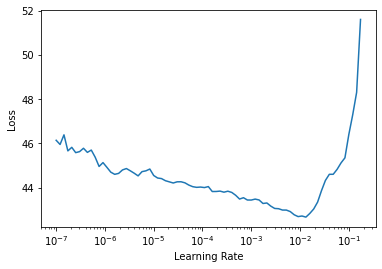

In [ ]:
learner = Learner(dls, mod, loss_func=ssd_loss, metrics=met).to_fp16()
learner.freeze()
# lr_min, lr_steep = learner.lr_find()

In [ ]:
# lr = (lr_min+lr_steep)/2; print("lr:",round(lr,4))

lr: 0.0007


In [ ]:
# learner.fit_one_cycle(8, lr=1e-3)

epoch,train_loss,valid_loss,"MAE, Focal",time
0,42.672752,39.732784,"(13.21, 26.4)",00:09
1,37.745369,37.079563,"(13.72, 23.29)",00:09
2,32.323452,25.694563,"(10.31, 15.33)",00:09
3,28.393658,24.779272,"(10.38, 14.36)",00:09
4,25.600983,20.874424,"(9.0, 11.81)",00:09
5,23.411497,19.913418,"(8.64, 11.2)",00:09
6,21.817591,19.374847,"(8.24, 11.06)",00:09
7,20.762218,19.192310,"(8.19, 10.93)",00:09


In [ ]:
# learner.save('s1')
# learner.export('models/20201215_pascal2007_rory2.pkl')

In [ ]:
# learner.export('models/20201210_pascal2007.pkl')          # trained for 10 epochs
# learner.export('models/20201210_pascal2007_bad.pkl')      # trained for 5 epochs
# learner.export('models/20201211_pascal2007_focalfix.pkl') # corrected weight in focal loss
# learner.export('models/20201215_pascal2007_rory.pkl')     # corrected bugs in anchor code

# mAP

In [ ]:
### get preds from acts ###
def nms(boxes, scores, iou_t, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort asc
    idx = idx[-top_k:]       # indices of k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= iou thresh
        idx = idx[IoU.le(iou_t)]
    return keep, count

def get_1_pred(idx, acts, conf_t, device):
    
    b_bb, b_clas = acts
    a_ic = actn_to_bb(b_bb[idx], anchors, device) #rm: added device

    conf_scores = b_clas[idx].sigmoid().t().data

    confs,pbbs,plbls = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > conf_t
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 40)
        ids = ids[:count]

        confs.append(scores[ids])
        pbbs.append(boxes.data[ids])
        plbls.append([cl]*count)

    # setting -1s to prevent an empty tensor error if no predictions > conf_thresh
    if not plbls: plbls = tensor([-1])
    else:         plbls = tensor(np.concatenate(plbls)) 
    if not confs: confs = tensor([[-1.,]])
    else:         confs = torch.cat(confs)
    if not pbbs:  pbbs = tensor([[-1., -1., -1., -1.]])
    else:         pbbs = torch.cat(pbbs)

    return pbbs, plbls, confs

def get_batch_preds(acts, conf_t, device):
    """Loop through a batch and of activations and turn them into predictions."""
    bbs, lbls, confs = [], [], []
    for i in range(bs):
        bb, lbl, conf = get_1_pred(i, acts, conf_t, device)
        bbs += [bb]
        lbls += [lbl]
        confs += [conf]
    return bbs, lbls, confs

In [ ]:
### Metric ###
def format_inps_batch(acts, batch, anchors, box_size, iou_t=.5, conf_t=.3, device='cuda'):
    """Format acts and targs for AP score calc. Input expects learner.acts & learner.batch,
       output format: (im_idx, pred_bbs, pred_cls, cls_conf) and (im_idx, bbs, cls).
       Ex: (46.0, tensor([0.1, 0.2, 0.9, 0.9]), tensor(3), tensor(0.78))"""
    preds = get_batch_preds(acts, anchors, box_size, iou_t, conf_t, device)
    p_idxs  = torch.cat([torch.tensor([i]*len(o)) for i,o in enumerate(preds[0])]).numpy().tolist()
    batch_preds = list(zip(p_idxs, *[torch.cat(o) for o in preds]))
    
    unp = [remove_padding(b,l) for b,l in zip(batch[1],batch[2])]
    unp = [o[0] for o in unp], [o[1] for o in unp]
    unp_flat = torch.cat(unp[0]), torch.cat(unp[1])
    gt_idxs = torch.cat([torch.tensor([i]*len(o)) for i,o in enumerate(unp[0])]).numpy().tolist()
    batch_gts = list(zip(gt_idxs, *unp_flat))
    
    return batch_preds, batch_gts
def ap_per_cls(batch_preds, batch_gts, iou_t=.5):
    """Calculate AP score per class. Returns AP for each class.
       https://www.youtube.com/watch?v=FppOzcDvaDI"""
    avg_precs,preds_out,tally,ntps,nfps = [],[],[],[],[]
    debug=[]
    for c in range(dls.ncls): # start at 1 to ignore gt
        # store preds and gts for current cls
        preds = [b for b in batch_preds if b[2]==c]
        gts   = [b for b in batch_gts   if b[2]==c]
                
        # sort preds by conf desc
        preds.sort(key=lambda x: x[3], reverse=True)
        
        # make dict of im_idx:zeros(n_objs)
        n_objs = Counter([gt[0] for gt in gts])
        for k,v in n_objs.items(): n_objs[k] = torch.zeros(v)
        
        # init tp: a bool tensor for each im s.t. 1s indicate a pred is a tp
        tp = torch.zeros((len(preds))).bool()
        total_gt_objs = len(gts)
        
        for pred_idx, pred in enumerate(preds):
            gt_objs = [o for o in gts if o[0] == pred[0]]
            n_gt_objs = len(gt_objs)
            max_iou = 0
            
            for idx, gt in enumerate(gt_objs):
                iou = get_iou(pred[1].view(1,4), gt[1].view(1,4))
                if iou > max_iou: max_iou, idx_of_max = iou, idx
                    
            # update idx of gt_obj to indicate it's been used
            if max_iou > iou_t:
                if n_objs[pred[0]][idx_of_max]==0:
                    tp[pred_idx] = 1
                    n_objs[pred[0]][idx_of_max] = 1
        
        # calc avg_prec and store
        tps = torch.cumsum(tp, dim=0)               # 1. tp csum: [0,1,1,0,0] → [0,1,2,2,2]
        fps = torch.cumsum(~tp, dim=0)              # (basically same steps for fp)
        prec = torch.div(tps, (tps + fps + 1e-6))   # 2. divide each tps item by n_preds
        prec = torch.cat((torch.tensor([1]), prec)) # 3. slap on a 1 at the beginning
        rec = tps / (total_gt_objs + 1e-6)
        rec = torch.cat((torch.tensor([0]), rec))
        avg_prec = torch.trapz(prec, rec) # calc AP w/ trap rule
        avg_precs.append(avg_prec)        # store AP of this cls in accum
        
        # store data for reporting
#         preds_out.append(([preds,tp]))
        tally.append(n_objs) #needs processing
        ntps.append(agg_ten(tps,max))
        nfps.append(agg_ten(fps,max))
        
        #debug
        debug.append([tps,fps,prec,rec])
        
    fn_bools = [[~dct[k].bool() for k in dct] for dct in tally]
    fns = [sum([agg_ten(t,sum) for t in tl]) for tl in fn_bools]
    return avg_precs, (ntps,nfps,fns), debug
def get_ap_scores(dls, model, ancs, anc_sz, iou_t, conf_t, device='cpu'):
    for o in [dls, model, anchors, box_size]: o.to(device)
    model.eval()

    aps,tps,tallies = [],[],[]
    for b in dls.valid:
        ap,tp,tally = ap_per_cls(model(b[0]),b,dls.ncls,ancs,anc_sz,iou_t,conf_t,device)
        aps.append(ap)
        tps.append(tp)
        tallies.append(tally)
    ap_scores = torch.stack([tensor(o) for o in res]).sum(axis=0)/len(res)
    ap_scores = ap_scores.numpy().tolist()
    return sum(ap_scores)/len(ap_scores), ap_scores
    
# functions for getting all preds and batches for mass-calculation of AP
from functools import partial
def get_all_preds(dls, mod, ancs, anc_sz, iou_t, conf_t, device):
    f = partial(get_batch_preds,ancs=ancs,anc_sz=anc_sz,
                iou_t=iou_t,conf_t=conf_t,device=device)
    # boip: batches ∍ (pbb,plbl,conf) ∍ ims ∍ preds
    boip = [f(mod(b[0])) for b in iter(dls)]
    # list(zip(*boip)) → obip; return oip s.t. len(o[0])==500
    return [flatten1(o) for o in list(zip(*boip))]
def get_all_batches(dls):
    bs = [b for b in iter(dls)]
    bst = list(zip(*bs))
    mx = max([o.shape[1] for o in bst[1]])
    bst[1] = [F.pad(o,pad=(0,0,0,mx-o.shape[1])) for o in bst[1]]
    bst[2] = [F.pad(o,pad=(0,mx-o.shape[1])) for o in bst[2]]
    return [torch.cat(o) for o in bst]
def format_inps_all(dls, mod, ancs, anc_sz, iou_t=.5, conf_t=.3, device='cuda'):
    """Format acts and targs for AP score calc. Input expects learner.acts & learner.batch,
       output format: (im_idx, pred_bbs, pred_cls, cls_conf) and (im_idx, bbs, cls).
       Ex: (46.0, tensor([0.1, 0.2, 0.9, 0.9]), tensor(3), tensor(0.78))"""
    
    preds = get_all_preds(dls, mod, ancs, anc_sz, iou_t, conf_t, device)
    p_idxs  = torch.cat([torch.tensor([i]*len(o)) for i,o in enumerate(preds[0])]).numpy().tolist()
    batch_preds = list(zip(p_idxs, *[torch.cat(o) for o in preds]))
    
    bs = get_all_batches(dls)
    unp = [remove_padding(b,l,False) for b,l in zip(bs[1],bs[2])]
    unp = [o[0] for o in unp], [o[1] for o in unp]
    unp_flat = torch.cat(unp[0]), torch.cat(unp[1])
    gt_idxs = torch.cat([torch.tensor([i]*len(o)) for i,o in enumerate(unp[0])]).numpy().tolist()
    batch_gts = list(zip(gt_idxs, *unp_flat))
    return batch_preds, batch_gts

In [ ]:
class ShowLosses(Metric):
    def __init__(self):   self.bb,self.lbl = [],[]
    def reset(self):      self.bb,self.lbl = [],[] 
    def accumulate(self): pass
    @property
    def value(self):      return avg_list(self.bb,2), avg_list(self.lbl,2)
    @property
    def name(self):       return "MAE, Focal"

# Show Results

## show_bb and ResultShower

In [ ]:
# show_bb and ResultShower
def show_bb(im, bb=None, lbl=[''], title=None, color='white',
            ctx=None, sz=im_sz, figsize=5):
    # process empties and nones
    if bb.shape[-1]==0 or bb==None: bb  = tensor([[0.,0,0,0]])
    if lbl==['']:                   lbl = ['']*bb.shape[0]
        
    # process tensors to take advantage of fastai show methods
    bbox = TensorBBox((bb+1)*sz//2)
    labeledbbox = LabeledBBox(bbox,lbl)
    
    if ctx:     show_image(im, figsize=[figsize,figsize], title=title, ctx=ctx)
    else: ctx = show_image(im, figsize=[figsize,figsize], title=title)
    
    labeledbbox.show(ctx=ctx)       # first, draw white lbl bbs...
    bbox.show(ctx=ctx, color=color) # ... then overlay color bbs.
    return ctx

In [ ]:
class ResultShower():
    def __init__(self, batch, acts, conf_t):
        im, self.bb, self.lbl = batch
        
        preds = get_batch_preds(acts,conf_t,'cpu')
        self.pbb, self.plbl, self.confs = preds
        
        self.im_sz = im.shape[-1]
        self.im = dls.decode(batch)[0]
        self.bs = dls.bs
        self.v  = dls.vocab
        self.last = 0
        
    def __call__(self, *args, **kwargs):
        return self.show_next(*args, **kwargs)
    
    def __getitem__(self, i, figsize=[12,12]):
        bb,  lbl      = remove_padding(self.bb[i], self.lbl[i])
        pbb, plbl, im = self.pbb[i], self.plbl[i], self.im[i]
        ctx = get_grid(2, figsize=figsize)
        show_bb(im,bb, self.v[lbl] ,'GTs'  ,'white'  ,ctx[0],self.im_sz)
        show_bb(im,pbb,self.v[plbl],'Preds','magenta',ctx[1],self.im_sz)
                 
    def show_next(self, n=1):
        for i in range(n): self[(i + self.last)%self.bs]
        self.last += n

## viz results

In [ ]:
# mod = load_learner('models/20201215_pascal2007_rory2.pkl').model # mod = learner.model
# batch = next(iter(dls.cpu().valid))
# acts = mod(batch[0])

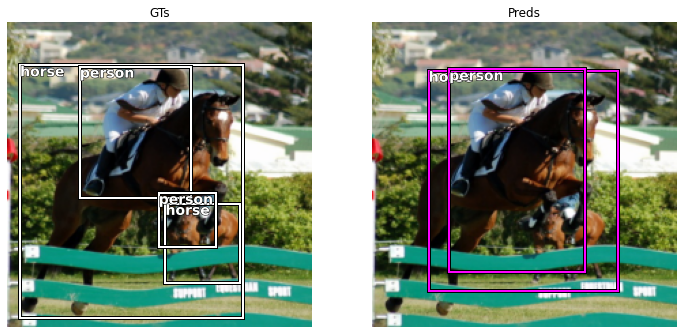

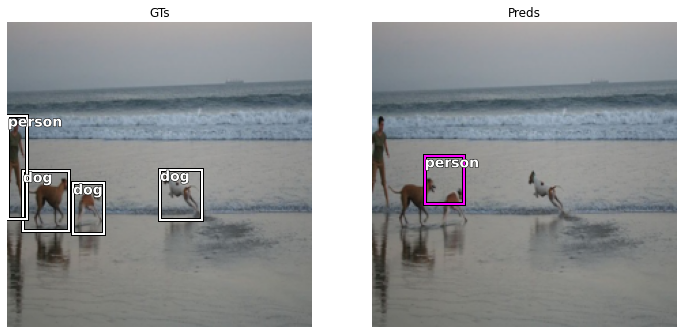

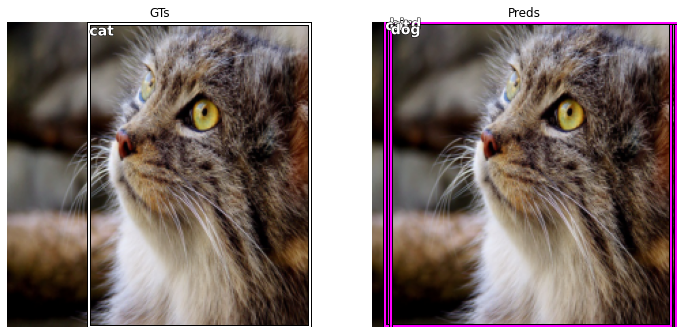

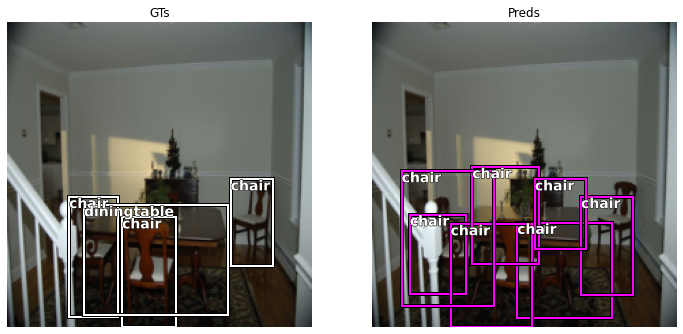

In [ ]:
res = ResultShower(batch, acts, .25)
res(4)

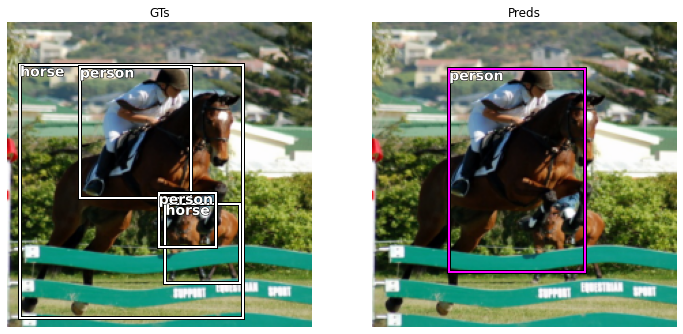

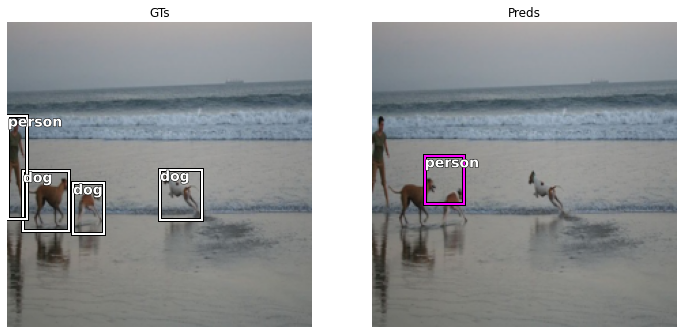

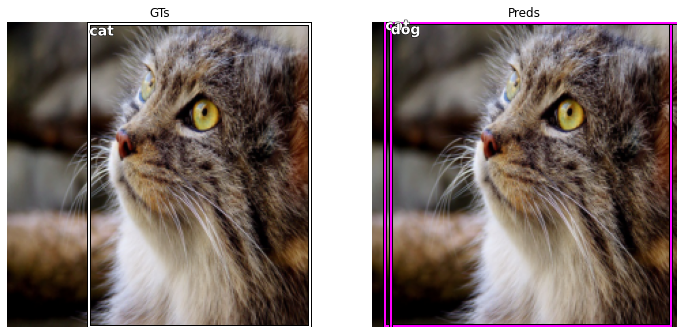

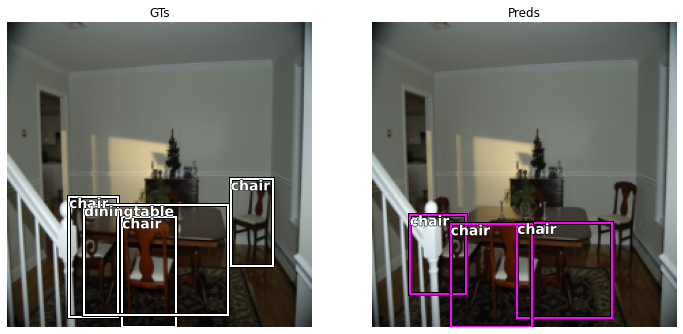

In [ ]:
res = ResultShower(batch, acts, .3)
res(4)

In [ ]:
# def test_confs(confs):
#     for conf in confs:
#         final,_ = get_ap_scores(dls, learner.model, anchors.cpu(), box_size.cpu(), .5, conf, 'cpu')
#         print(f"mAP for conf {conf:.2f}: {round(final,3)}")
# test_confs([round(.05*x,2) for x in range(1,11)])

In [ ]:
# # show ap per cls, desc
# sum_scores, scores = get_ap_scores(dls,learner.model,anchors.cpu(),box_size.cpu(),.5,.3,'cpu')
# print("mAP:",round(sum_scores,3))
# pd.DataFrame({'Class':dls.v, 'AP':[round(o,3) for o in scores]}).sort_values('AP',ascending=False)

# Stepping Through a Batch

In [ ]:
# init
device='cpu'
subdivs = [4, 2, 1]
zooms   = [0.75, 1.0, 1.3]
ratios  = [(1.,1.), (1.,.5), (.5,1)]
k = len(zooms) * len(ratios)

anchors, box_size = create_anchors(subdivs, zooms, ratios, device)
anchor_boxes = hw2pp(anchors[:,:2], anchors[:,2:])
loss_f = FocalLoss(dls.ncls, device)

body = create_body(resnet34, pretrained=True)
head = SSDHead(k, -4., 0.4, 'resnet34')
# mod = CustMod(body, head)
# mod = load_learner('models/20201215_pascal2007_rory.pkl').model   # saved learner
mod = load_learner('models/20201215_pascal2007_rory2.pkl').model   # saved learner

## Loss

### `batch`,`acts`, & `abb,albl,bb,lbl`

In [ ]:
batch = next(iter(dls.to(device).valid))
ims, bbs, lbls = batch
acts = mod(ims)
abbs, albls = acts
dec_ims = dls.decode(batch)[0]

In [ ]:
# Grab everything for a single item
i=0; abb,albl,bb,lbl,dec_im = list(zip(abbs,albls,bbs,lbls,dec_ims))[i]

Am I padding my data with "aeroplane"?? Yes, but they get removed with the remove padding step.

In [ ]:
bb, lbl

(tensor([[-0.9177, -0.7167,  0.5527,  0.9417],
         [-0.5219, -0.7125,  0.2134,  0.1583],
         [ 0.0437,  0.1958,  0.5321,  0.7083],
         [-0.0026,  0.1167,  0.3728,  0.4792],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]]),
 tensor([12, 14, 12, 14,  0,  0,  0,  0,  0,  0,  0,  0]))

In [ ]:
rpbb, rplbl = remove_padding(bb, lbl)
rpbb, rplbl

(tensor([[-0.9177, -0.7167,  0.5527,  0.9417],
         [-0.5219, -0.7125,  0.2134,  0.1583],
         [ 0.0437,  0.1958,  0.5321,  0.7083],
         [-0.0026,  0.1167,  0.3728,  0.4792]]),
 tensor([12, 14, 12, 14]))

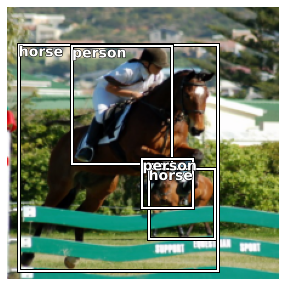

In [ ]:
show_bb(dec_im, rpbb, dls.v[rplbl]);

Acts have the right shape:

In [ ]:
abbs.shape,albls.shape

(torch.Size([64, 189, 4]), torch.Size([64, 189, 21]))

Act bboxes do not have a -1 to 1 range; that happens with a tanh during get_pred_bbs.

In [ ]:
abbs.min(), abbs.max()

(tensor(-16.4468, grad_fn=<MinBackward1>),
 tensor(18.9555, grad_fn=<MaxBackward1>))

In [ ]:
torch.tanh(abbs).min(), torch.tanh(abbs).max()

(tensor(-1., grad_fn=<MinBackward1>), tensor(1., grad_fn=<MaxBackward1>))

Act lbls have an interesting range:

In [ ]:
albls.min(), albls.max()

(tensor(-33.9528, grad_fn=<MinBackward1>),
 tensor(1.3717, grad_fn=<MaxBackward1>))

Batch has the right shape, too:

In [ ]:
bbs.min(), bbs.max()

(TensorBBox(-1.), TensorBBox(1.))

In [ ]:
lbls.min(), lbls.max()

(TensorMultiCategory(0), TensorMultiCategory(19))

##### detour: acts to preds

In [ ]:
"""Turn model acts into preds: abbs use get_pred_bbs, and albls use sigmoid().max()."""
# convert acts to preds
pbb = get_pred_bbs(abb, anchors, device)

In [ ]:
pbb.shape

torch.Size([189, 4])

In [ ]:
albl.sigmoid().shape

torch.Size([189, 21])

In [ ]:
confs, plbl = albl.sigmoid().max(1)

In [ ]:
# filter out preds w/ nms
nms_idxs, nms_n = nms(pbb.data, confs, .4)
nms_idxs = nms_idxs[:nms_n]
pbb   = pbb[nms_idxs]
plbl  = plbl[nms_idxs]
confs = confs[nms_idxs]
# filter out bg and low-conf preds
is_not_bg = (plbl!=20)
is_confident = confs > conf_t
mask = is_not_bg & is_confident
ret =  pbb[mask], plbl[mask], confs[mask]

##### end detour

### ssd item loss

In [ ]:
#assignments
act_bbs, act_lbls, bbs, lbls = abb,albl,bb,lbl

In [ ]:
bbs,lbls = remove_padding(bbs,lbls)                      # remove gt padding inserted during training
bbs,lbls

(tensor([[-0.9177, -0.7167,  0.5527,  0.9417],
         [-0.5219, -0.7125,  0.2134,  0.1583],
         [ 0.0437,  0.1958,  0.5321,  0.7083],
         [-0.0026,  0.1167,  0.3728,  0.4792]]),
 tensor([12, 14, 12, 14]))

In [ ]:
pred_bbs = get_pred_bbs(act_bbs, anchors, device) # make 196 pred bbs from acts and ancs
pred_bbs.shape, pred_bbs

(torch.Size([189, 4]),
 tensor([[-0.9623, -0.8595, -0.6470, -0.5271],
         [-0.9832, -0.8448, -0.7210, -0.6366],
         [-0.7858, -0.8946, -0.6076, -0.5842],
         [-0.8342, -0.9208, -0.4909, -0.6166],
         [-0.9902, -0.9478, -0.6539, -0.6273],
         [-0.8869, -0.9388, -0.6920, -0.5204],
         [-0.9407, -0.9882, -0.4994, -0.3780],
         [-0.8682, -0.9776, -0.4517, -0.6217],
         [-0.8850, -0.9306, -0.5674, -0.4657],
         [-0.5203, -0.9414, -0.2598, -0.5786],
         [-0.3771, -0.9016, -0.1550, -0.6469],
         [-0.2820, -0.8905, -0.1322, -0.6476],
         [-0.4196, -0.8686, -0.0361, -0.4450],
         [-0.5318, -0.8440, -0.1896, -0.5569],
         [-0.3209, -1.0063, -0.0751, -0.6061],
         [-0.3250, -0.8610,  0.1293, -0.3005],
         [-0.2423, -0.8611,  0.1144, -0.5296],
         [-0.3682, -0.8055, -0.0642, -0.3341],
         [ 0.0935, -0.9110,  0.3734, -0.6133],
         [ 0.2137, -0.8422,  0.4154, -0.6489],
         [ 0.1258, -0.8693,  0.2751, 

In [ ]:
(2*anchor_boxes-1).min()

tensor(-1.3000)

In [ ]:
i=0

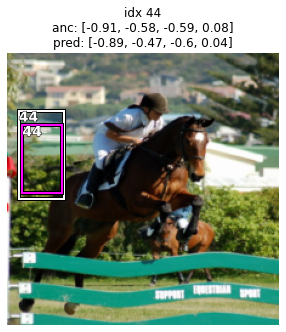

In [ ]:
# ctx = get_grid(2, figsize=[12,12])
anc_bbs = 2*hw2pp(anchors[:,:2],anchors[:,2:])-1

tit_a = [round(i,2) for i in list(anc_bbs[i].data.numpy())]
tit_p = [round(i,2) for i in list(pred_bbs[i].data.numpy())]
title=f'idx {i}\nanc: {tit_a}\npred: {tit_p}'
ctx = show_bb(dec_im, anc_bbs[i].unsqueeze(0), [i], title=title)  # anchors on left
show_bb(      dec_im, pred_bbs[i].unsqueeze(0), [i], ctx=ctx, color='magenta')
i+=1

In [ ]:
act_bbs.min(), act_bbs.max()

(tensor(-4.5691, grad_fn=<MinBackward1>),
 tensor(4.8974, grad_fn=<MaxBackward1>))

In [ ]:
pred_bbs.min(), pred_bbs.max() 

(tensor(-1.1323, grad_fn=<MinBackward1>),
 tensor(1.1158, grad_fn=<MaxBackward1>))

#### detour: ancs

This is not so bad. Let's look at the ancs and the preds.

In [ ]:
i=0
anc_bbs = 2*hw2pp(anchors[:,:2],anchors[:,2:])-1

Why on earth are all of the preds moving to the borrom right, and small???

In [ ]:
i=170

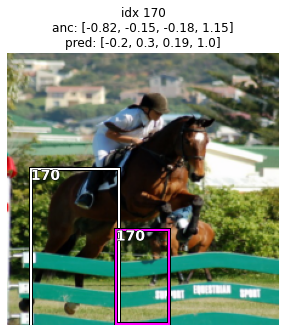

In [ ]:
# ctx = get_grid(2, figsize=[12,12])
anc_bbs = 2*hw2pp(anchors[:,:2],anchors[:,2:])-1
tit_a = [round(i,2) for i in list(anc_bbs[i].data.numpy())]
tit_p = [round(i,2) for i in list(pred_bbs[i].data.numpy())]
title=f'idx {i}\nanc: {tit_a}\npred: {tit_p}'
ctx = show_bb(dec_im, anc_bbs[i].unsqueeze(0), [i], title=title)  # anchors on left
show_bb(      dec_im, pred_bbs[i].unsqueeze(0), [i], ctx=ctx, color='magenta')
i+=1

In [ ]:
def get_pred_bbs(act_bbs, ancs, device):
    # scale acts to between -1,1; ancs still on unit scale
    abbs_tanh = torch.tanh(act_bbs)
    # move anc centers by up to half a grid size in each dir
    pctrs = ancs.to(device)[:,:2] + (abbs_tanh.to(device)[:,:2]   * box_size.to(device)/2) 
    # scale the hws by .5 to 1.5 (+/- 50%)
    phws  = ancs.to(device)[:,2:] * (abbs_tanh.to(device)[:,2:]/2 +    1                 )
    # return result in reunit scale
    return 2*hw2pp(pctrs, phws)-1

In [ ]:
def get_pred_bbs_x(act_bbs, ancs, device):
    # scale acts to between -1,1; ancs still on unit scale
    abbs_tanh = act_bbs
    # move anc centers by up to half a grid size in each dir
    pctrs = ancs.to(device)[:,:2] + (abbs_tanh.to(device)[:,:2]   * box_size.to(device)/2) 
    # scale the hws by .5 to 1.5 (+/- 50%)
    phws  = ancs.to(device)[:,2:] * (abbs_tanh.to(device)[:,2:]/2 +    1                 )
    # return result in reunit scale
    return 2*hw2pp(pctrs, phws)-1

In [ ]:
i=170

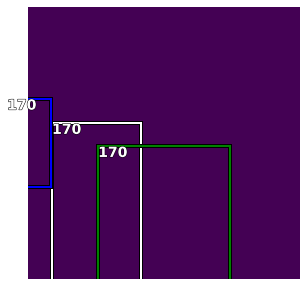

In [ ]:
vsmol = get_pred_bbs_x(torch.ones(act_bbs.shape)*-1, anchors, device)
vbig  = get_pred_bbs_x(torch.ones(act_bbs.shape), anchors, device)
ctx = show_bb(torch.zeros(im_sz,im_sz), anc_bbs[i].unsqueeze(0), [i]) 
show_bb(torch.zeros(im_sz,im_sz), vbig[i].unsqueeze(0), [i], ctx=ctx, color='green') 
show_bb(torch.zeros(im_sz,im_sz), vsmol[i].unsqueeze(0), [i], ctx=ctx, color='blue') 
i+=1

These aren't broken. I think the classes aren't correctly influencing the loss function.

In [ ]:
###############
####  END  ####
###############

#### continuing

In [ ]:
# map gt to preds
iou_gt_grid = get_iou(bbs.data, anchor_boxes.data)
iou_gt_grid.shape, iou_gt_grid[0:3,:5], iou_gt_grid.min(), iou_gt_grid.max()

(torch.Size([4, 189]),
 tensor([[0.0144, 0.0072, 0.0072, 0.0256, 0.0128],
         [0.0355, 0.0227, 0.0184, 0.0505, 0.0314],
         [0.0143, 0.0000, 0.0081, 0.0370, 0.0000]]),
 tensor(0.),
 tensor(0.5619))

In [ ]:
# let's trt again...
iou_gt_grid = get_iou(bbs.data, 2*anchor_boxes.data-1)
iou_gt_grid.shape, iou_gt_grid[0:3,:5], iou_gt_grid.min(), iou_gt_grid.max()

(torch.Size([4, 189]),
 tensor([[0.0217, 0.0086, 0.0117, 0.0348, 0.0152],
         [0.0000, 0.0000, 0.0000, 0.0052, 0.0025],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]),
 tensor(0.),
 tensor(0.6878))

In [ ]:
iou_gt_preds, mapped_gt_idx = map_to_gt(iou_gt_grid)     # assign each pred an index of a gt object
iou_gt_preds[0:8], mapped_gt_idx

(tensor([0.0217, 0.0086, 0.0117, 0.0348, 0.0152, 0.0216, 0.0529, 0.0246]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3,
         2, 3, 3, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

Compare against SG's code:

In [ ]:
def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

In [ ]:
map_to_ground_truth(iou_gt_grid)[1]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3,
        2, 3, 3, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Looks good.

In [ ]:
mapped_lbls = lbls[mapped_gt_idx]               # project gt lbls into pred space
lbls, mapped_gt_idx, mapped_lbls

(tensor([12, 14, 12, 14]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3,
         2, 3, 3, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14,
         14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 12, 12, 12, 12, 12, 12, 12, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14,
         14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        

In [ ]:
# remove low-iou bb preds & set mapped lbl to bg
high_iou = iou_gt_preds > 0.4       # only include bb preds that overlap w/a gt obj and
high_iou

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False,  True,  True,  True,  True, False,  True,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

In [ ]:
incl = torch.nonzero(high_iou).squeeze()
incl

tensor([ 51,  90,  92,  93,  94,  95,  97,  98, 172, 175, 180, 182, 183, 184,
        185, 187, 188])

In [ ]:
mapped_lbls[~high_iou] = dls.ncls               # assign gt class of 20 (bg)
high_iou, mapped_lbls

(tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
          True, False,  True,  True,  True,  True, False,  True,  True, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, F

In [ ]:
mapped_bbs = bbs[mapped_gt_idx]                # project gt bbs into pred space
bbs,mapped_gt_idx,mapped_bbs

(tensor([[-0.9177, -0.7167,  0.5527,  0.9417],
         [-0.5219, -0.7125,  0.2134,  0.1583],
         [ 0.0437,  0.1958,  0.5321,  0.7083],
         [-0.0026,  0.1167,  0.3728,  0.4792]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3,
         2, 3, 3, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([[-0.9177, -0.7167,  0.5527,  0.9417],
         [-0.9177, -0.7167,  0.5527,  0.9417],
         [-0.9177, -0.7167,  0.5527,  0.9417],
         [-0.9177, -0.7167, 

In [ ]:
i=0

I thought that this pred wouldn't be included? What does it overlap with?

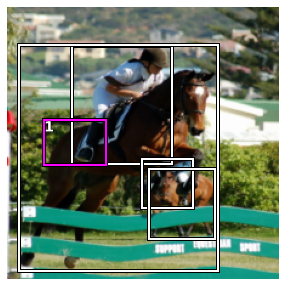

In [ ]:
ctx = show_bb(dec_im, mapped_bbs[incl])
show_bb(dec_im, pred_bbs[incl][i].unsqueeze(0), [i], ctx=ctx, color='magenta')
i+=1

In [ ]:
# compute loss
bb_res  = F.l1_loss(pred_bbs[incl], mapped_bbs[incl])
bb_res

tensor(0.3273, grad_fn=<L1LossBackward>)

In [ ]:
lbl_res = loss_f(act_lbls.cpu(), mapped_lbls.cpu())
lbl_res

tensor(0.6793, grad_fn=<DivBackward0>)

### lbl loss

In [ ]:
# lbl_loss
#assignments
acts, targs = act_lbls.cpu(), mapped_lbls.cpu()

In [ ]:
t = one_hot_embedding(targs, dls.ncls+1, device)
t.shape, t

(torch.Size([189, 21]),
 tensor([[0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]]))

In [ ]:
t = tensor(t[:,:-1].contiguous())
t.shape, t

(torch.Size([189, 20]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [ ]:
a = acts[:,:-1]
a.shape, a

(torch.Size([189, 20]),
 tensor([[-3.9891, -4.1691, -4.0815,  ..., -4.1617, -3.9448, -4.2141],
         [-3.9118, -3.8588, -4.1509,  ..., -3.9471, -4.1068, -4.4997],
         [-3.9061, -4.0771, -4.0870,  ..., -4.1831, -3.9755, -3.9879],
         ...,
         [-3.9870, -4.0060, -3.9948,  ..., -3.9976, -4.0073, -3.9924],
         [-3.9988, -3.9908, -4.0037,  ..., -4.0180, -4.0328, -3.9996],
         [-4.0175, -4.0025, -4.0115,  ..., -3.9883, -4.0004, -3.9869]],
        grad_fn=<SliceBackward>))

In [ ]:
def get_weight(a, t):
    alpha, gamma = 0.25, 2.0 # vals from paper
    p = a.sigmoid()
    pt = p*t + (1-p)*(1-t)
    w = alpha*t + (1-alpha)*(1-t)
    return w * (1-pt).pow(gamma)

In [ ]:
w = get_weight(a,t).detach()
w.shape, w

(torch.Size([189, 20]),
 tensor([[2.4787e-04, 1.7398e-04, 2.0673e-04,  ..., 1.7655e-04, 2.7037e-04,
          1.5923e-04],
         [2.8849e-04, 3.2002e-04, 1.8033e-04,  ..., 2.6919e-04, 1.9670e-04,
          9.0596e-05],
         [2.9171e-04, 2.0851e-04, 2.0448e-04,  ..., 1.6924e-04, 2.5457e-04,
          2.4844e-04],
         ...,
         [2.4890e-04, 2.3979e-04, 2.4511e-04,  ..., 2.4376e-04, 2.3919e-04,
          2.4626e-04],
         [2.4322e-04, 2.4704e-04, 2.4087e-04,  ..., 2.3420e-04, 2.2750e-04,
          2.4284e-04],
         [2.3443e-04, 2.4144e-04, 2.3722e-04,  ..., 2.4827e-04, 2.4243e-04,
          2.4896e-04]]))

## AP

### Dave Luo mAP

In [ ]:
### copied functions and params
grid_sizes = box_size
anchor_cnr = anchor_boxes
jaccard = get_iou

get_y = remove_padding
actn_to_bb = get_pred_bbs
hw2corners = hw2pp

In [ ]:
### copied viz functions
import matplotlib.cm as cmx
import matplotlib.colors as mcolors

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

def bb_to_hw(bb):
    return [bb[1],bb[0],bb[3]-bb[1], bb[2]-bb[0]]

def show_img(im, figsize=None, axis=None):
    if not axis:
        fig,axis = plt.subplots(figsize=figsize)
    axis.imshow(im)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    return axis

def draw_outline(obj,lw):
    obj.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(axis, box, color='white'):
    patch = axis.add_patch(patches.Rectangle(box[:2],box[-2],box[-1],fill=False,edgecolor=color,lw=2))
    draw_outline(patch,4)
    
def draw_text(axis,xy,text,text_size=14, color='white'):
    patch = axis.text(*xy, text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
    draw_outline(patch,1)
    
def show_img_all(id_img):
    img = open_image(IMG_PATH/imgs_fn[id_img])
    axis = show_img(img, figsize=(16,8))
    for bbox, id_cat in trn_anno[id_img]:
        new_box = bb_to_hw(bbox)
        draw_rect(axis, new_box)
        draw_text(axis, new_box[:2], cats[id_cat])
        
def show_ground_truth(ax, im, bbox, clas = None, prs = None, tresh = 0.3):
    bb = [bb_to_hw(o) for o in bbox.reshape(-1,4)]
    if clas is None: clas = [None] * len(bb)
    if prs is None: prs = [None] * len(bb)
    ax = show_img(im,axis=ax)
    for i, (b,c,pr) in enumerate(zip(bb,clas,prs)):
        if b[2] > 0 and (pr is None or pr > tresh):#Show the bow only if there is something to show
            draw_rect(ax, b, colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c == len(id2cats) else id2cats[c])
            if pr is not None: txt += f'{pr:.2f}'
            draw_text(ax,b[:2],txt,color=colr_list[i%num_colr])
        
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

In [ ]:
x,y1,y2 = next(iter(dls.cpu().valid))
y = (y1,y2)
batch = mod(x)
x = to_np(x)

In [ ]:
def get_pred(idx, x, y, batch, md_thres=0.35, display=False):

    b_bb, b_clas = batch
    bbox, clas = get_y(y[0][idx], y[1][idx])

    a_ic = actn_to_bb(b_bb[idx], anchors, device) #rm: added device

    conf_scores = b_clas[idx].sigmoid().t().data

    out1,out2,cc = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > md_thres
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 40)
        ids = ids[:count]

        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)

    # setting -1s to prevent an empty tensor error if no predictions > model_thres
    if not cc: cc = tensor([-1])
    else: cc = tensor(np.concatenate(cc)) 
    if not out1: out1 = tensor([[-1.,]])
    else: out1 = torch.cat(out1)
    if not out2: out2 = tensor([[-1., -1., -1., -1.]])
    else: out2 = torch.cat(out2)

    pr = (cc, out1, out2) # class, conf, bb
    gt = (clas.data, bbox.data) # class, bb

    if display:
        ima=dls.decode([x,*y])[0][idx]
        show_img_3col(ima, pr, gt)

    return pr, gt

In [ ]:
# get preds, gts for im 0
idx = 0
pr, gt = get_pred(idx,x,y,batch)
pr, gt

((tensor([-1]), tensor([[-1.]]), tensor([[-1., -1., -1., -1.]])),
 (tensor([12, 14, 12, 14]),
  tensor([[-0.9177, -0.7167,  0.5527,  0.9417],
          [-0.5219, -0.7125,  0.2134,  0.1583],
          [ 0.0437,  0.1958,  0.5321,  0.7083],
          [-0.0026,  0.1167,  0.3728,  0.4792]])))

In [ ]:
def show_img_3col(ima, pr, gt, figsize=(15, 30)):
    pr_cl, pr_conf, pr_bb = pr
    gt_cl = gt[0]
    gt_bb = gt[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    if to_np(pr_conf)[0] >= 0: str_obj = str(len(pr_conf)) 
    else: str_obj = '0'
    title1_str = 'Preds: '+ str_obj
    show_bb(ima, pr_bb, dls.v[pr_cl], title1_str, ctx=ax1);

    title2_str = 'GTs: '+ str(len(gt_cl))
    show_bb(ima, gt_bb, dls.v[gt_cl], title2_str, ctx=ax2);

In [ ]:
# count TP, FP, FN for a single image in a single class, assuming that class is in both prediction and ground truth

def tpfpfn_1img(conf_pr, bb_pr, bb_gt, thres):
    '''
    mostly borrowed from https://gist.github.com/tarlen5/008809c3decf19313de216b9208f3734 starting line 80
    ''' 
    
    # calc IoUs for every prediction to every gt object. If > threshold, add to idx counters
    pr_overthres_idx = []
    gt_overthres_idx = []
    #ious_overthres = [] # sort by confidence instead of IoU
    conf_overthres = []
    for i, pr in enumerate(bb_pr):
        for j, gt in enumerate(bb_gt):
            pr = tensor(pr).cpu()
            gt = tensor(gt).cpu()

            overlap = to_np(jaccard(gt.unsqueeze(0), pr.unsqueeze(0)))
            if overlap >= thres:
                #print(i, j, overlap)
                pr_overthres_idx.append(i)
                gt_overthres_idx.append(j)
                #ious_overthres.append(float(overlap))
                conf_overthres.append(conf_pr[i])
    
    # sort idx in order of highest confidence first, change from IoU sorting approach
    idxsorted = np.argsort(conf_overthres)[::-1]
    
    # for each match, check if already counted as detected or not. if not, add to idx counter
    gt_match_idx = []
    pr_match_idx = []
    for idx in idxsorted:
        gt_idx = gt_overthres_idx[idx]
        pr_idx = pr_overthres_idx[idx]
        #print(id_pred_overthres[idx], id_gt_overthres[idx])
        if pr_idx not in pr_match_idx and gt_idx not in gt_match_idx:
            gt_match_idx.append(gt_idx)
            pr_match_idx.append(pr_idx)

    tp = len(gt_match_idx)
    fp = len(bb_pr) - len(pr_match_idx)
    fn = len(bb_gt) - tp
    
    return tp, fp, fn

In [ ]:
def oneclass_tpfpfn_1img(cat, idx, pr, gt, iou_thres):
    
    pr_cl, pr_conf, pr_bb = pr
    gt_cl = gt[0]
    gt_bb = gt[1]
    
    pr_cl = pr_cl.cpu()
    pr_conf = pr_conf.cpu()
    pr_bb = pr_bb.cpu()
    gt_cl = gt_cl.cpu()
    gt_bb = gt_bb.cpu()

    tp = 0
    fp = 0
    fn = 0
    
    if cat in pr_cl and cat in gt_cl:
        bb_gt = gt_bb[list(np.argwhere(cat == gt_cl))]
        bb_pr = pr_bb[list(np.argwhere(cat == pr_cl))]
        tp, fp, fn = tpfpfn_1img(pr_conf, bb_pr, bb_gt, iou_thres)
        
    elif cat in pr_cl and cat not in gt_cl: # every detection counts as a false pos
        fp = len(pr_bb[list(np.argwhere(cat == pr_cl))]) 
        
    elif cat not in pr_cl and cat in gt_cl: # every gt obj counts as a false neg
        fn = len(gt_cl[list(np.argwhere(cat == gt_cl))]) 
        
    gt_c = len(np.argwhere(to_np(gt[0])==cat))
    return tp,fp,fn,gt_c

In [ ]:
def nclass_tpfnfn_1img(cats, idx, x,y,batch, md_thres=0.25, iou_thres=0.5, display=True, verbose=True):
    
    pr, gt = get_pred(idx,x,y,batch, md_thres, display)
    
    if verbose: print('TP FP FN GTc   Category')
        
    for cat in cats:
        cl_str = dls.v[cat]
        tp,fp,fn,gt_c = oneclass_tpfpfn_1img(cat, idx, pr, gt, iou_thres)
        
        if verbose: 
            if np.any([tp,fp,fn,gt_c]): print(f'{tp}  {fp}  {fn}  {gt_c}      {dls.v[cat]} (cat{cat})')  

TP FP FN GTc   Category
1  0  1  2      horse (cat12)
0  1  2  2      person (cat14)


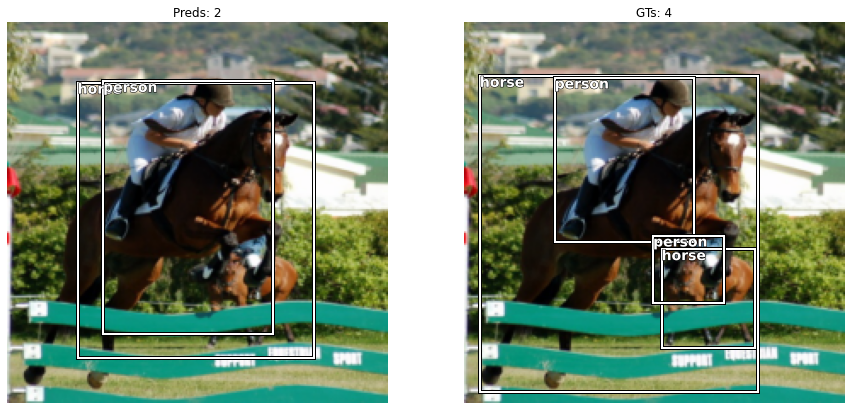

In [ ]:
conf_t = .25
nclass_tpfnfn_1img(range(20), 0, x, y, batch, conf_t)

TP FP FN GTc   Category
0  0  3  3      dog (cat11)
0  1  1  1      person (cat14)


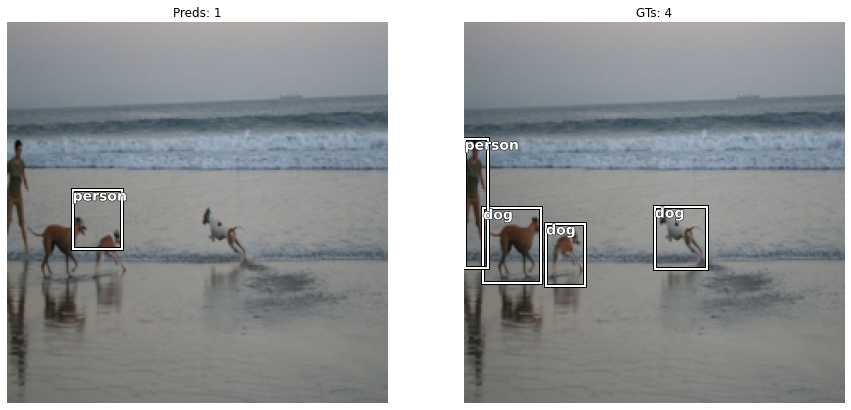

In [ ]:
nclass_tpfnfn_1img(range(20), 1, x, y, batch, conf_t)

TP FP FN GTc   Category
0  1  0  0      bird (cat2)
1  0  0  1      cat (cat7)
0  1  0  0      dog (cat11)


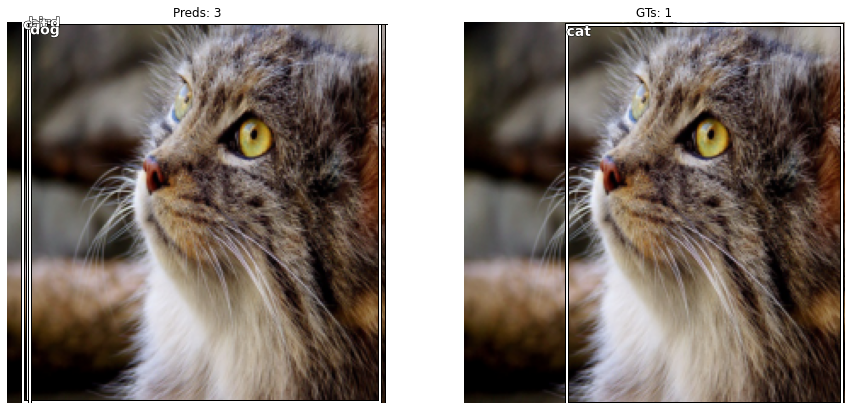

In [ ]:
nclass_tpfnfn_1img(range(20), 2, x, y, batch, conf_t)

In [ ]:
def count(l):
    res = collections.defaultdict(int)
    if l is not None:
        for x in l: res[x] += 1
    return res

In [ ]:
def all_tpfpfn(md_thres_rng, iou_thres, cats):
    
    ## Init ##
    tps = np.zeros((dls.ncls, len(md_thres_rng)))       
    fps = np.zeros((dls.ncls, len(md_thres_rng)))       
    fns = np.zeros((dls.ncls, len(md_thres_rng)))         # shape: (20,91). tps is full of zeros.     
    gt_c = np.zeros(dls.ncls)                             # shape: (20). gt_c is full of zeros.
    b_count = 0

    # loop thru batches
    for data in dls.cpu().valid:
        start = time.time()
        ## Get data and model activations ##
        x,y1,y2 = data                                         # ims, bbs, cls
        y = (y1,y2)                                            # (x,y) is from the valid dataset
        batch = mod(tensor(x))                                 # batch is the output of model(x)
        b_clas,b_bb = batch
        b_count +=1

        # loop thru n=bs imgs
        for idx in range(len(y[0])):                                    
            ## Calc TPs and TPs for increasingly higher conf threshes ##
            pr, gt = get_pred(idx, x, y, batch, np.min(md_thres_rng))     # grab preds at min conf thresh (.05)

            # loop thru conf threshes
            for i, md_thres in enumerate(md_thres_rng):                                   # if any confs > thresh,
                if np.any(to_np(pr[1]) > md_thres):                                       #  then get mask.
                    masked_idx = tensor(np.argwhere(to_np(pr[1]) > md_thres)).squeeze()   #  else, we're done
                else: break                                                               #  calculating TPs&FPs.
                pr_masked = (pr[0][masked_idx], pr[1][masked_idx], pr[2][masked_idx])     # apply mask to preds

                # loop thru classes
                for cat in cats:
                    tp,fp,_,_ = oneclass_tpfpfn_1img(cat, idx, pr_masked, gt, iou_thres)
                    tps[cat,i] += tp
                    fps[cat,i] += fp

            ## Calc FNs ##
            # dave: calc FNs separately because pr masking and loop break above
            # dave: misses FNs at higher thresh where there are no predictions
            for cat in cats: gt_c[cat] += count(gt[0].numpy())[cat]
            fns = np.repeat(np.expand_dims(gt_c, axis=1),n, axis=1) - tps
            
        end = time.time();
        s_elapsed = round(end - start, 1)
        print(f'Completed batch {b_count} of {len(dls.valid)} ({s_elapsed}s)')
        
    return tps, fps, fns

In [ ]:
# n = 50
# md_thres_rng = np.linspace(.05, 0.95, n, endpoint=True)
# iou_thres = 0.5
# cats = range(dls.ncls)

# tps1, fps1, fns1 = all_tpfpfn(md_thres_rng, iou_thres, cats)

Completed batch 1 of 8 (5.8s)
Completed batch 2 of 8 (6.5s)
Completed batch 3 of 8 (5.6s)
Completed batch 4 of 8 (5.6s)
Completed batch 5 of 8 (6.3s)
Completed batch 6 of 8 (6.3s)
Completed batch 7 of 8 (6.3s)
Completed batch 8 of 8 (5.3s)


In [ ]:
# from datetime import datetime
# today = datetime.today().strftime('%Y%m%d')
# fname1 = f'models/{today}_tps1_{n}step.npy'
# fname2 = f'models/{today}_fps1_{n}step.npy'
# fname3 = f'models/{today}_fns1_{n}step.npy'
# np.save(fname1, tps1)
# np.save(fname2, fps1)
# np.save(fname3, fns1)
# print(f"Saved to '{fname1}', '{fname2}', and '{fname3}'.")

Saved to 'models/20201218_tps1_50step.npy', 'models/20201218_fps1_50step.npy', and 'models/20201218_fns1_50step.npy'.


In [ ]:
tps1 = np.load(fname1) # 'models/20201218_tps1_50step.npy' 'models/20201217_tps1_50step.npy'
fps1 = np.load(fname2) # 'models/20201218_fps1_50step.npy' 'models/20201217_fps1_50step.npy'
fns1 = np.load(fname3) # 'models/20201218_fns1_50step.npy' 'models/20201217_fns1_50step.npy'

In [ ]:
cls_ix=0
thr_ix=4
tps1[cls_ix][thr_ix], fps1[cls_ix][thr_ix], fns1[cls_ix][thr_ix]

(20.0, 256.0, 23.0)

**AP @ IoU>.5 per category**

In [ ]:
#rm fxns
def get_mask(arr):
    return np.argwhere(arr).flatten()
def diagonal_area(precs):
    chunks = []
    def _avg(p1,p2): return (p1+p2)/2
    for i in range(10): chunks.append(_avg(precs[i],precs[i+1]))
    return sum(chunks)/10

In [ ]:
def avg_prec(precisions, recalls):
    prec_at_rec = []
    for rec in np.linspace(0.0, 1.0, 11):    # [0, .1, .2,,, 1]. Ex: rec=.5
        try:                                 # recalls >= rec   → [Tr,Tr,Tr,Fa,Fa,Fa,Fa,Fa,...]
            mask = get_mask(recalls >= rec)  # get_mask         → [0,1,2]=mask
            prec = max(precisions[mask])     # precisions[mask] → [.011,.043,.051]; max() → .051
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)             # prec_at_rec = [1.0, .83, .45, .30, .11, .07, 0,0,0,0,0]
    return diagonal_area(prec_at_rec)

In [ ]:
def calc_prec_reca(tps, fps, fns, cat):
    eps = np.spacing(1)
    precision = tps[cat,:] / (tps[cat,:]+fps[cat,:] + eps)
    recall    = tps[cat,:] / (tps[cat,:]+fns[cat,:] + eps)
    ap = avg_prec(precision, recall)
    
    return ap, precision, recall

In [ ]:
def draw_prcurves(tps, fps, fns):
    fig, axes = plt.subplots(5, 4, figsize=(24, 30))
    aps = []
    
    for i_cls,ax in enumerate(axes.flat):  
        ap, precision, recall = calc_prec_reca(tps, fps, fns, i_cls)
        aps.append(ap)
        ax.plot(recall, precision)
        ax.set_xlim(0,1.1)
        ax.set_ylim(0,1.1)
        ax.set_title(f'{i_cls} {dls.v[i_cls]}, AP: {ap:4.4f}')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        
    plt.tight_layout()
    
    return aps

In [ ]:
# # 11pt interpolated precision
# prec_at_rec = []
# for rec in np.linspace(0.0, 1.0, 11):   # [0, .1, .2,,, 1]. Ex: rec=.5
#     try:                                # recalls >= rec   → [Tr,Tr,Tr,Fa,Fa,Fa,Fa,Fa,...]
#         mask = get_mask(recalls >= rec) # get_mask         → [0,1,2]=mask
#         prec = max(precisions[mask])    # precisions[mask] → [.011,.043,.051]; max() → .051
#     except ValueError:
#         prec = 0.0
#     prec_at_rec.append(prec)            # prec_at_rec = [1.0, .83, .45, .30, .11, .07, 0,0,0,0,0]

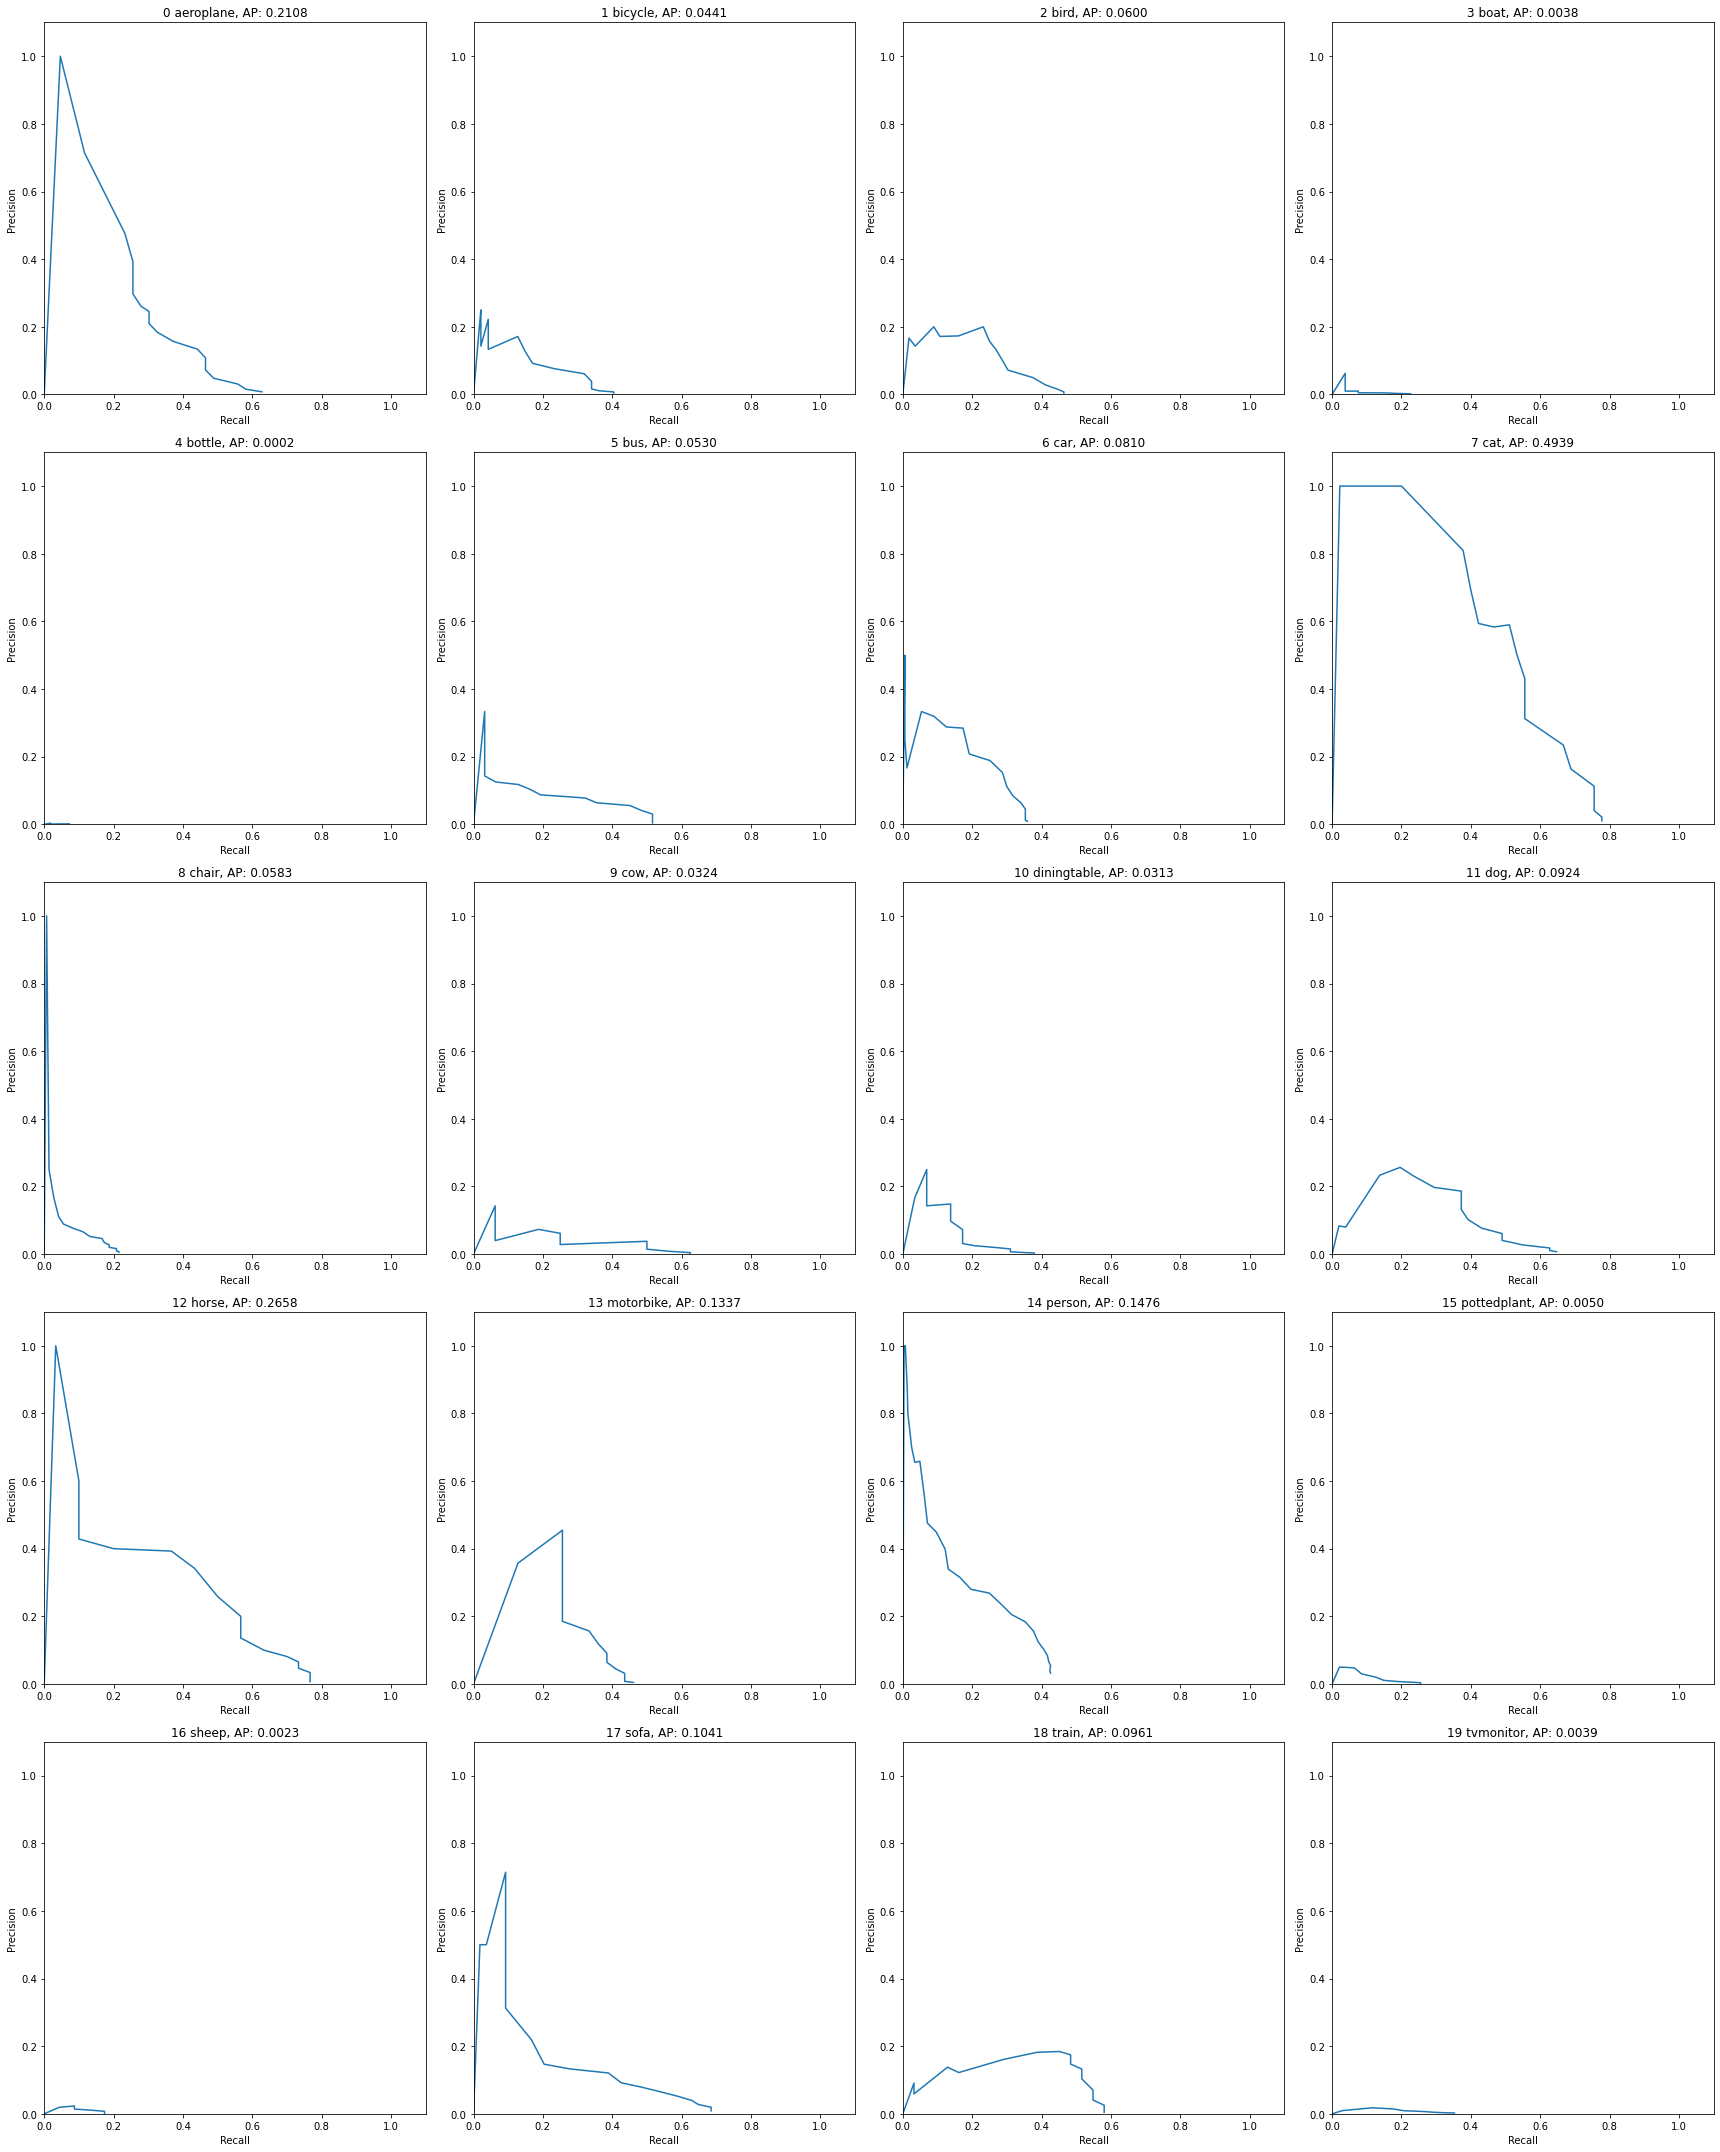

In [ ]:
aps1 = draw_prcurves(tps1, fps1, fns1)

In [ ]:
sum(aps1)/len(aps1)

0.0959806954362736

### Calculating mAP

###### format inputs

In [ ]:
# get batch of preds (pred_bbs, pred_lbls, pred_confs)
iou_thresh=.5
conf_thresh=.3
preds = get_batch_preds(acts, anchors, box_size, iou_thresh, conf_thresh, device)

In [ ]:
# out of interest: how many preds?
n_preds = torch.cat(preds[0]).shape[0]
n_preds

135

In [ ]:
unp = [remove_padding(b,l,False) for b,l in zip(batch[1],batch[2])]
unp = [o[0] for o in unp], [o[1] for o in unp]
unp_flat = torch.cat(unp[0]), torch.cat(unp[1])

In [ ]:
# get list of im idxs containing each pred (used in mAP algorithm)
p_idxs  = torch.cat([torch.tensor([i]*len(o)) for i,o in enumerate(preds[0])]).numpy().tolist()
gt_idxs = torch.cat([torch.tensor([i]*len(o)) for i,o in enumerate(unp[0])]).numpy().tolist()

In [ ]:
batch_preds = list(zip(p_idxs, *[torch.cat(o) for o in preds]))
batch_preds

[(0.0,
  tensor([-0.3964, -0.6585,  0.4472,  0.7216]),
  tensor(14),
  tensor(0.4489)),
 (0.0,
  tensor([-0.2058, -0.7428,  0.3694,  0.2123]),
  tensor(14),
  tensor(0.4188)),
 (1.0,
  tensor([-0.8118,  0.0033, -0.5204,  0.3782]),
  tensor(14),
  tensor(0.3651)),
 (2.0,
  tensor([-0.9212, -1.0978,  0.9875,  0.9936]),
  tensor(7),
  tensor(0.6503)),
 (2.0,
  tensor([-0.8433, -0.6127,  1.1810,  0.3928]),
  tensor(7),
  tensor(0.3050)),
 (3.0,
  tensor([-0.1082,  0.2558,  0.5228,  0.9645]),
  tensor(8),
  tensor(0.4751)),
 (3.0,
  tensor([-0.4371,  0.2209,  0.1259,  1.0206]),
  tensor(8),
  tensor(0.4260)),
 (3.0,
  tensor([-0.0981, -0.0264,  0.4014,  0.5821]),
  tensor(8),
  tensor(0.3560)),
 (3.0,
  tensor([-0.3673,  0.0883, -0.0183,  0.6392]),
  tensor(8),
  tensor(0.3467)),
 (3.0,
  tensor([-0.6955,  0.4008, -0.2635,  0.9906]),
  tensor(8),
  tensor(0.3260)),
 (3.0,
  tensor([-0.9313,  0.1074, -0.3092,  0.9473]),
  tensor(8),
  tensor(0.3188)),
 (3.0, tensor([0.1617, 0.1668, 0.8498, 0

In [ ]:
batch_gts = list(zip(gt_idxs, *unp_flat))
batch_gts

[(0, tensor([-0.9177, -0.7167,  0.5527,  0.9417]), tensor(12)),
 (0, tensor([-0.5219, -0.7125,  0.2134,  0.1583]), tensor(14)),
 (0, tensor([0.0437, 0.1958, 0.5321, 0.7083]), tensor(12)),
 (0, tensor([-0.0026,  0.1167,  0.3728,  0.4792]), tensor(14)),
 (1, tensor([-0.9000, -0.0190, -0.5960,  0.3688]), tensor(11)),
 (1, tensor([-0.5640,  0.0570, -0.3640,  0.3840]), tensor(11)),
 (1, tensor([ 0.0040, -0.0342,  0.2800,  0.3004]), tensor(11)),
 (1, tensor([-1.0000, -0.3840, -0.8680,  0.2928]), tensor(14)),
 (2, tensor([-0.4640, -0.9893,  0.9880,  1.0000]), tensor(7)),
 (3, tensor([0.4720, 0.0301, 0.7440, 0.6024]), tensor(8)),
 (3, tensor([-0.2480,  0.2831,  0.1080,  1.0000]), tensor(8)),
 (3, tensor([-0.5960,  0.1446, -0.2760,  0.9337]), tensor(8)),
 (3, tensor([-0.4960,  0.1988,  0.4480,  0.9277]), tensor(10)),
 (4, tensor([-0.8040, -0.8187,  1.0000,  0.9147]), tensor(6)),
 (5, tensor([ 0.0259, -0.4200,  0.7752,  0.7400]), tensor(1)),
 (5, tensor([-0.7406, -0.3200,  0.0432,  0.6320]), ten

###### Final mAP Score

In [ ]:
# debug contains 20 lists; each list contains tps,fps,prec,rec for a class
tps1r = debug[0][0]

In [ ]:
all_preds, all_gts = format_inps_all(dls.cpu().valid, mod, anchors, box_size, .5, 0, 'cpu')
aps, tpfpfns, debug = ap_per_cls(all_preds, all_gts)
map_score = sum(aps)/len(aps)
print(f"mAP: {map_score:.3f}")

pd.DataFrame({
    "Class":dls.v,
    "AP":[round(o.item(),2) for o in aps],
    "TPs":tpfpfns[0],
    "FPs":tpfpfns[1],
    "FNs":tpfpfns[2]
}).sort_values('AP',ascending=False)

mAP: 0.116


,Class,AP,TPs,FPs,FNs
7,cat,0.43,26,390,19
18,train,0.23,17,899,14
14,person,0.23,263,7077,286
6,car,0.22,60,4026,107
0,aeroplane,0.21,12,813,31
2,bird,0.21,20,928,36
12,horse,0.17,11,231,19
13,motorbike,0.14,9,211,30
11,dog,0.13,19,572,32
10,diningtable,0.08,6,127,23
